### Generalized Lotka-Volterra

$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\N}{\mathcal{N}}$
$\newcommand{\ddt}[1]{\dfrac{d #1}{ dt}}$

Following the analysis in *Robust and Scalable Models of Microbiome Dynamics* Gibson and Gerber ICMLR 2018

The gLV equation for a population vector $ x \in \R^+$ are

$$ \ddt{x} = x \cdot (a_{1} + a_{2}x + B x) + \xi.$$  

Here $a_1$ is the vector of growth rates, $a_2$ is the vector of "self interactions," $B$ is a matrix of cross species interactions (with all diagonal equal to 0), and $\xi$ is a vector of noise where each element is iid from $\N(0, \sigma_w)$. 

Ill write down the model later but the priors for all of these parameters are Normal distributions with a different variance for each set of parameters (i.e. $\sigma_a$, $\sigma_b$). In reality (generally) $a_1 >0$ and $a_2<0$.

This model doesn't include the clustering aspect from the paper but ill cirle back to that. Below ill just sparsify the interaction matrix because that seems sensible.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
rc("text", usetex=True)
rc("font", family = "serif")
rc("figure",figsize=(9,6))
rc("figure",facecolor="white")
%config InlineBackend.figure_format = 'retina'

mpl.style.use('dark_background') #Use a dark background for matplotlib figures if youre using dark theme
plt.rcParams.update({"figure.facecolor": "111111",
                     "savefig.facecolor": "212121"})
import pymc3 as pm

In [3]:
from scipy import stats

### Simulation

In [4]:
# Some parameters
n_species = 13
interaction_sparsity = 0.4
sigma_a = 3
sigma_b = 2
sigma_w = 0.5

a1 = 20*np.ones(n_species)
a2 = -5*np.ones(n_species)
B = np.diag(a2)

cluster1 = np.array([1,5,7,9,11])-1
cluster2 = np.array([2,4,6,8,10,12])-1
cluster3 = np.array([3,13])-1

b12 = 3
b13 = -1
b31 = 2
b32 = -4

B[np.ix_(cluster1,cluster2)] = b12
B[np.ix_(cluster1,cluster3)] = b13
B[np.ix_(cluster3,cluster1)] = b31
B[np.ix_(cluster3,cluster2)] = b32

disp_order = np.concatenate((cluster1,cluster2,cluster3))


a = 5
loc = 0
scale = 1.5
gamma = stats.gamma(a, loc, scale)
x0 = gamma.rvs(n_species)

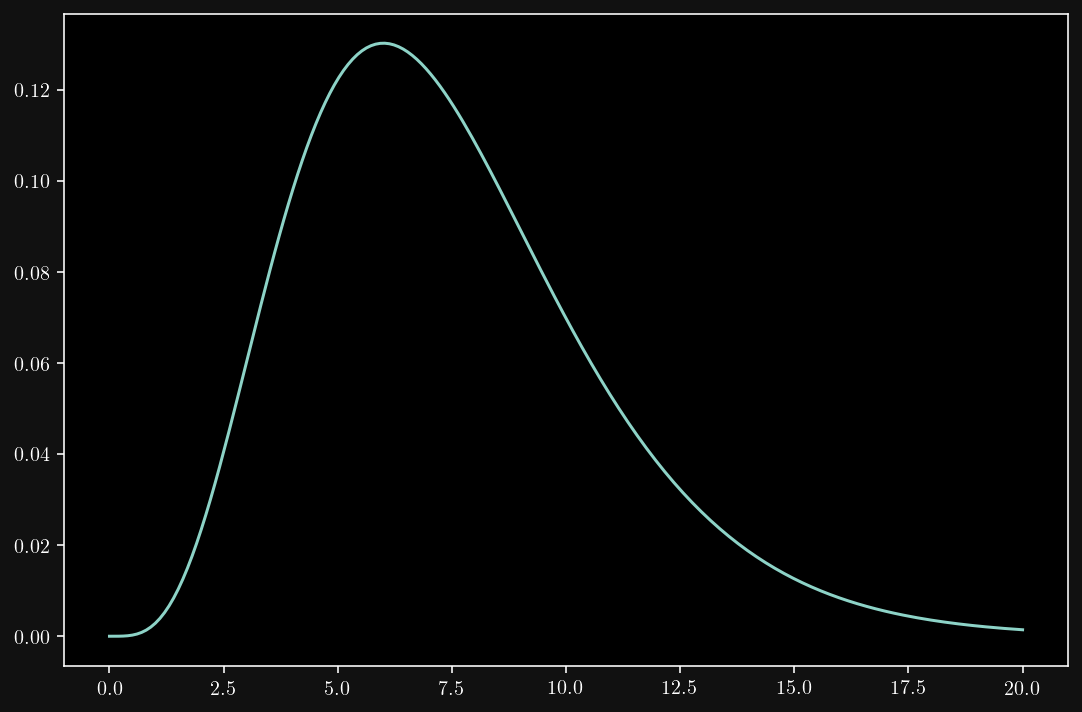

In [5]:
xplt = np.linspace(0,20,200)
plt.plot(xplt, gamma.pdf(xplt))
plt.show()

In [6]:
#Find self interaction terms that admit a non-negative equilibrium in the non stochastic case of gLV dynamics

max_iters = 1000
iters=0
while np.any(np.linalg.lstsq(B,-a1,rcond=None)[0]<0):
    a1 = 2+sigma_a*np.random.randn(n_species)
    iters += 1
    if iters==max_iters:
        print("Timed out")
        break

In [7]:
B[cluster1][:,cluster2]

array([[3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3.]])

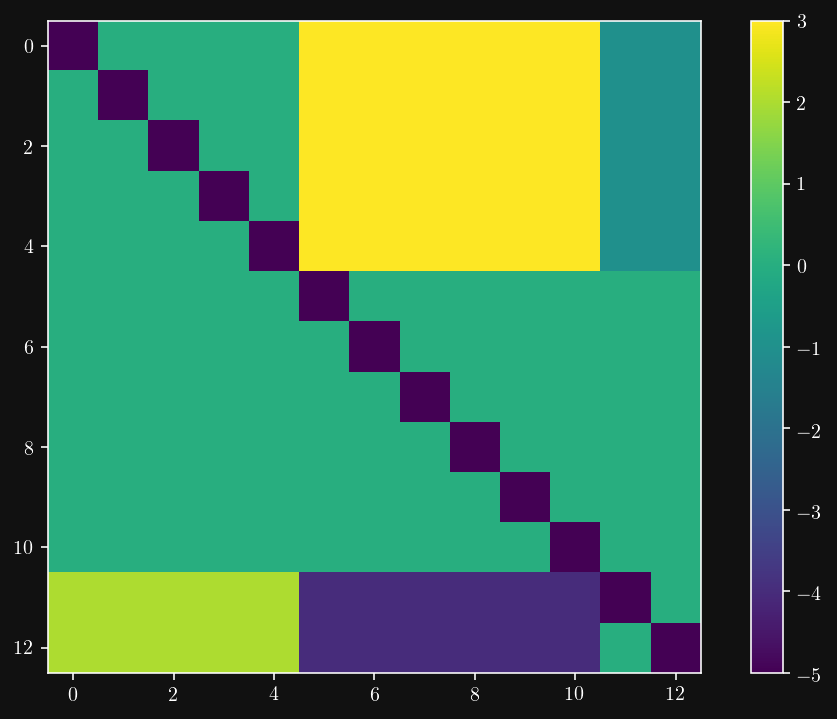

In [8]:
plt.imshow(B[disp_order][:,disp_order])
plt.colorbar()
plt.show()

In [9]:
T = 0.25
dt = 0.0025
n_steps = np.int(T/dt)+1
t_plot = np.linspace(0,T,n_steps)
n_reps = 5

X = np.zeros((n_steps, n_species, n_reps))
#B = np.zeros((n_species,n_species))
X[0] = gamma.rvs(X[0].shape)
for t in range(1, n_steps):
    X[t] = X[t-1] + dt*X[t-1]*(a1.reshape(-1,1) + B@X[t-1]) + np.sqrt(dt)*np.random.randn(n_species, n_reps)
    X[t][X[t]<0] = 0

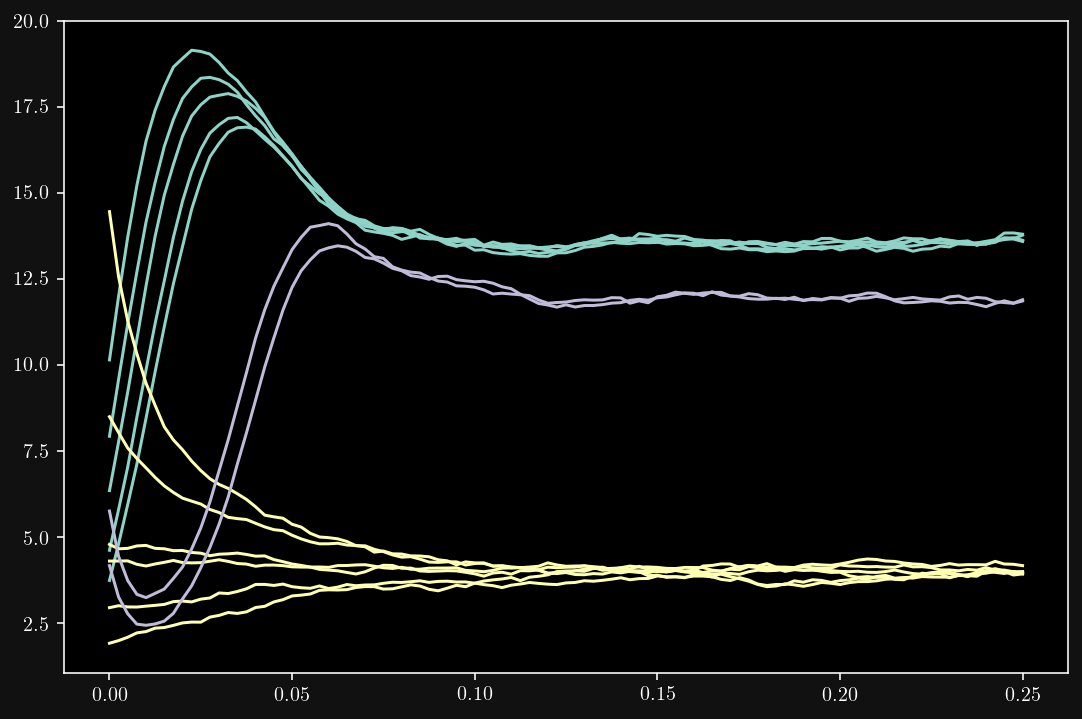

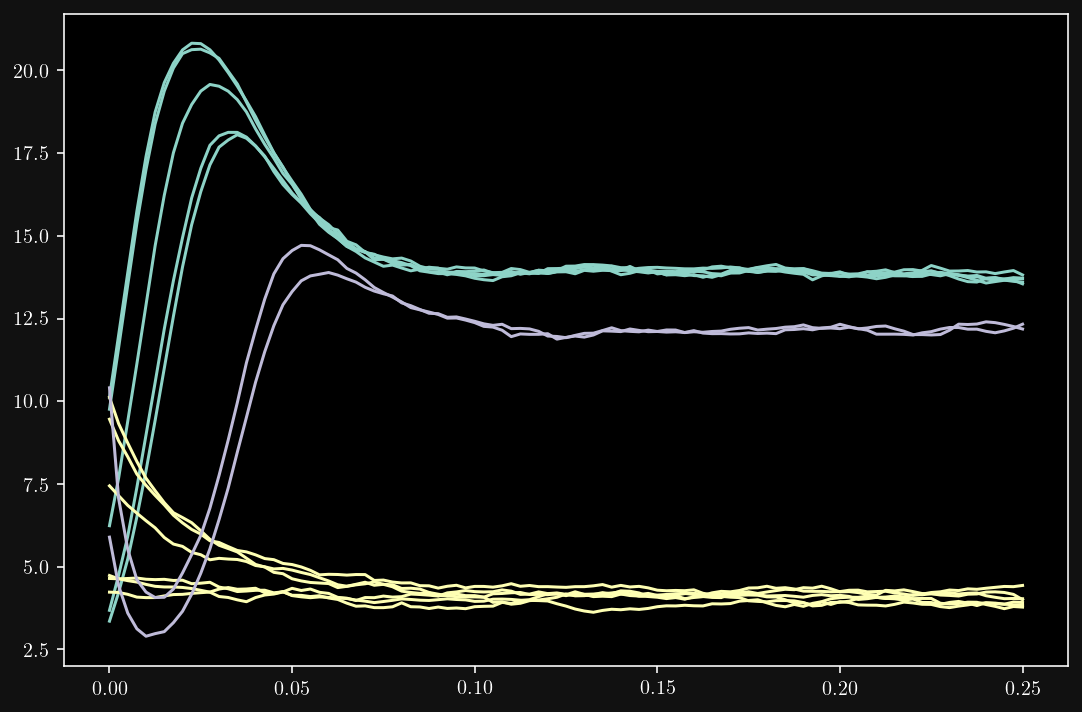

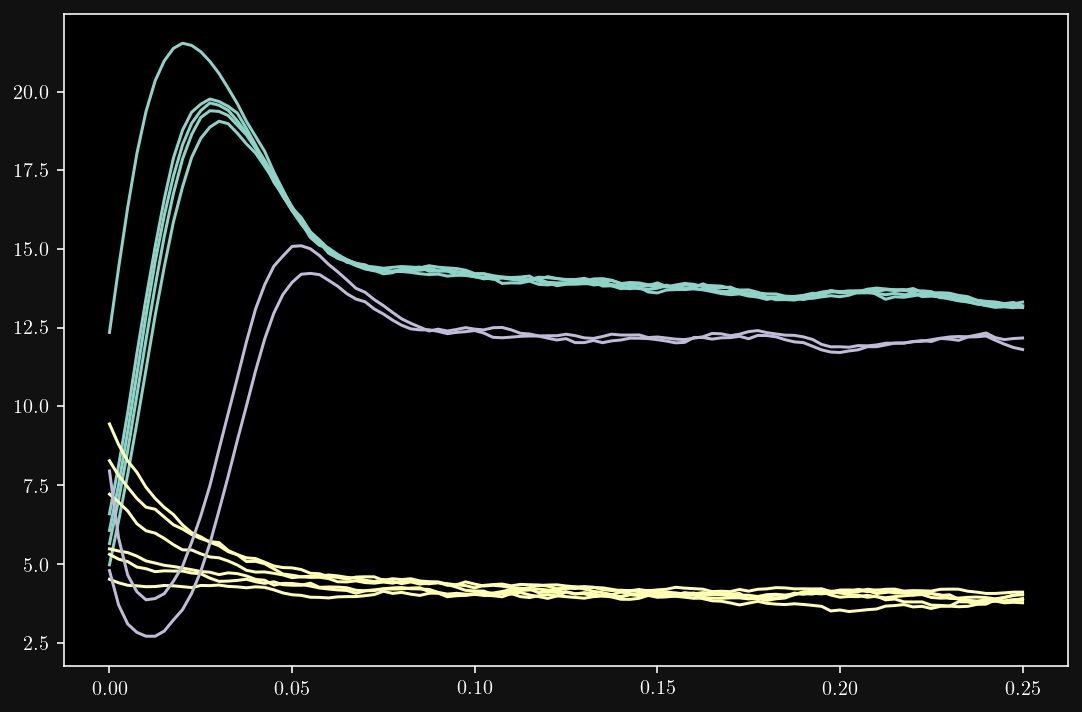

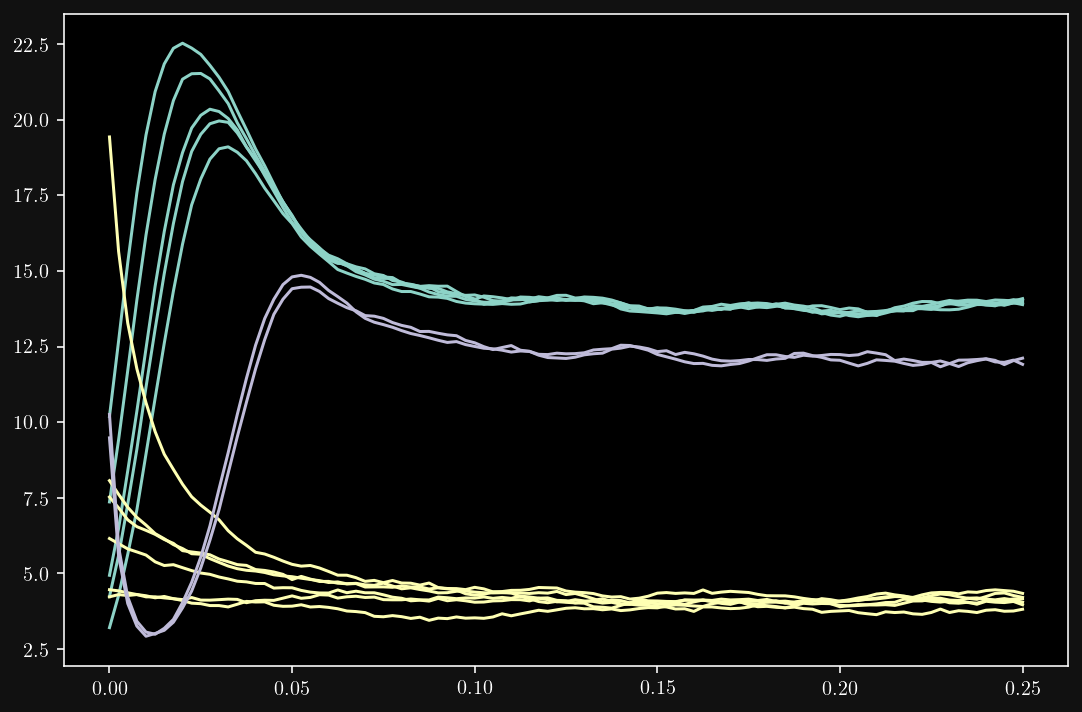

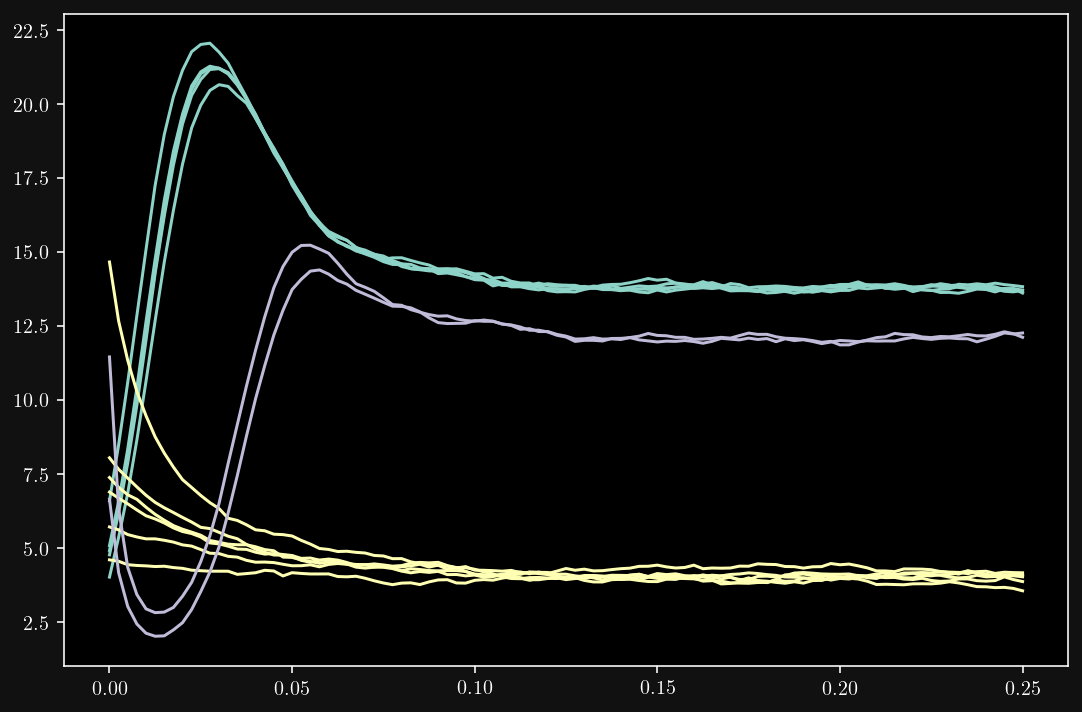

In [10]:
for r in range(n_reps):
    for i,cluster in enumerate([cluster1, cluster2, cluster3]):
        for species in cluster:
            plt.plot(t_plot, X[:,species, r],color=f'C{i}')
    plt.show()

In [197]:
N_replicates = 5

xtest = gamma.rvs((n_species,N_replicates))

In [198]:
out1 = (B@xtest)

In [11]:
def simulate_glv(n_replicates, T, dt, a, B):
    n_steps = np.int(T/dt)+1
    X = np.zeros((n_steps, n_species, n_replicates))
    X[0] = gamma.rvs(X[0].shape)
    for t in range(1, n_steps):
        X[t] = X[t-1] + dt*X[t-1]*(a.reshape(-1,1) + B@X[t-1]) + np.sqrt(dt)*np.random.randn(n_species,n_replicates)
        X[t][X[t]<0] = 0
    return X

In [12]:
X1 = simulate_glv(5, 0.25, 0.0025, a1, B)

In [13]:
data = X1[np.arange(11)*10]
t_data = np.linspace(0,.25,101)[np.arange(11)*10]

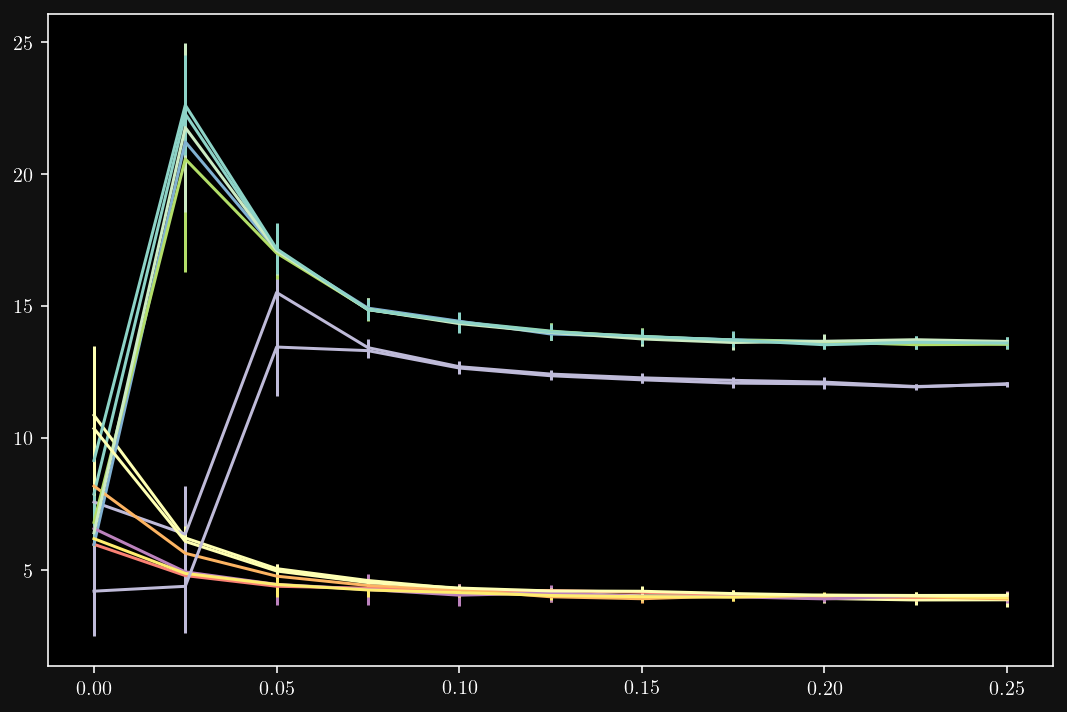

In [14]:
for i in range(n_species):
    plt.errorbar(t_data, data.mean(-1)[:,i], yerr=data.std(-1)[:,i])
plt.show()

In [42]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch
from pyro import poutine
torch.set_default_tensor_type(torch.DoubleTensor)

In [16]:
data_tensor = torch.tensor(data).permute(2,0,1)
time_tensor = torch.tensor(t_data)

In [33]:
data_tensor.shape

torch.Size([5, 11, 13])

In [57]:
def model(tpts,data):
    sigma_a = 3
    sigma_b = 5
    a = pyro.sample('a',dist.Normal(torch.zeros(n_species),3*torch.ones(n_species)).to_event(1))
    sigma_B = sigma_b*(torch.ones((n_species,n_species)) - torch.eye(n_species)) + sigma_a*torch.eye(n_species) 

    B = pyro.sample('B',dist.Normal(torch.zeros((n_species,n_species)),sigma_B).to_event(2))
    #for r in pyro.plate('replicates',data.shape[0]):
    for t in range(1,data.shape[1]):
        x_last = data[r,t-1]
        dt = tpts[t] - tpts[-1]
        mean = x_last*(torch.ones_like(x_last) + a + B.mv(x_last))
    #print(mean.shape)
    #print(data[:,t].shape)
        likelihood = dist.Normal(mean, torch.sqrt(dt)*torch.ones(n_species)).expand(data[:,t].shape).to_event(1)
        #print(likelihood.batch_shape)
        #print(likelihood.event_shape)
        x_t = pyro.sample('x_{}'.format(t), likelihood, obs=data[:,t])

In [58]:
model(time_tensor,data_tensor)

In [59]:
trace = poutine.trace(model).get_trace(time_tensor,data_tensor)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

Trace Shapes:          
 Param Sites:          
Sample Sites:          
       a dist   | 13   
        value   | 13   
     log_prob   |      
       B dist   | 13 13
        value   | 13 13
     log_prob   |      
     x_1 dist 5 | 13   
        value 5 | 13   
     log_prob 5 |      
     x_2 dist 5 | 13   
        value 5 | 13   
     log_prob 5 |      
     x_3 dist 5 | 13   
        value 5 | 13   
     log_prob 5 |      
     x_4 dist 5 | 13   
        value 5 | 13   
     log_prob 5 |      
     x_5 dist 5 | 13   
        value 5 | 13   
     log_prob 5 |      
     x_6 dist 5 | 13   
        value 5 | 13   
     log_prob 5 |      
     x_7 dist 5 | 13   
        value 5 | 13   
     log_prob 5 |      
     x_8 dist 5 | 13   
        value 5 | 13   
     log_prob 5 |      
     x_9 dist 5 | 13   
        value 5 | 13   
     log_prob 5 |      
    x_10 dist 5 | 13   
        value 5 | 13   
     log_prob 5 |      


In [60]:
nuts_kernel = NUTS(model,jit_compile=True)
mcmc = MCMC(nuts_kernel, num_samples=10, warmup_steps=5)

In [61]:
mcmc.run(time_tensor,data_tensor)

Warmup:   0%|          | 0/15 [00:00, ?it/s]

KeyboardInterrupt: 